In [27]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding,EarlyStoppingCallback
from datasets import DatasetDict, Dataset
import torch
import numpy as np
import evaluate
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
import time
import re

In [3]:
model_name = 'bert-base-uncased'
# FacebookAI/roberta-base


# microsoft/deberta-v3-large

In [4]:
model_name_saving = re.sub("/","_", model_name)
model_name_saving

'bert-base-uncased'

In [5]:
formatter = logging.Formatter('%(asctime)s %(lineno)s %(levelname)s %(message)s')
def setup_logger(name, log_file= model_name_saving +".log", level=logging.INFO):
    handler = logging.FileHandler(log_file)
    handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)
    return logger
logger = setup_logger("logger")

In [6]:
logger.info(f'Is Cuda available? {torch.cuda.is_available()}')

In [7]:
df = pd.read_csv("data\TrainingData_ParkStyle_2-0_forSukanya.csv")
logger.info(f'Original Data Size {len(df)}')
df["head_tail"] = df.apply(lambda x: str(x["head"]) + " " + str(x["tail"]), axis = 1)
df.dropna(subset= ["Park","sent","head_tail"],inplace=True)
logger.info(f'Dataset Size after dropping columns with null values {len(df)}')
df["Park"] = df["Park"].astype(int)

In [8]:
df_train, temp_df = train_test_split(df, test_size=0.30, stratify=df["Park"], random_state=42)
# Trying to ensure that all splits have all the classes
df_valid, df_test = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Park"], random_state=42)



data = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "valid": Dataset.from_pandas(df_valid),
    "test": Dataset.from_pandas(df_test)
})


In [9]:
logger.info(f'Train data size {len(data["train"])}')
logger.info(f'Validation data size {len(data["valid"])}')
logger.info(f'Test data size {len(data["test"])}')

In [10]:
logger.info(f'Training Class Distribution{dict(df_train.Park.value_counts()/len(df_train))}')
logger.info(f'Validation Class Distribution{dict(df_valid.Park.value_counts()/len(df_valid))}')
logger.info(f'Test Class Distribution{dict(df_test.Park.value_counts()/len(df_test))}')

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=df['Park'].nunique())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def tokenize_function(batch,max_length ):#= tokenizer
    tokenized_batch = tokenizer(text = batch["sent"], text_pair= batch["head_tail"], padding=True, max_length=max_length, truncation=True, return_tensors="pt")
    tokenized_batch["labels"] = batch["Park"] #label
    return tokenized_batch

# Tokenize dataset
tokenized_datasets = data.map(tokenize_function, batched=True, fn_kwargs={"max_length":tokenizer.model_max_length})
# Remove unwanted columns
tokenized_datasets = tokenized_datasets.remove_columns(["sentID", "sent", "head", "tail", "Park", "head_tail", "__index_level_0__"])
logger.info(f'Tokenization completed')

Map: 100%|██████████| 969/969 [00:00<00:00, 13360.77 examples/s]


In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results/"+model_name_saving,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub="False",
    greater_is_better=False,  # Since lower loss is better
    report_to="none"
)


In [14]:
accuracy = evaluate.load("accuracy")
# Define compute metrics funct

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    labels = labels.squeeze()
    return accuracy.compute(predictions=predictions, references=labels)


In [15]:
#4. Define data_collators
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True) #pads to the max sequence length in a batch

In [16]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator = data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] 
)



C:\Users\sukan\AppData\Local\Temp\ipykernel_34904\3907965586.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
logger.info(f'Training started')
start = time.time()
# Train model
trainer.train()
logger.info(f"Execution Time: {(time.time()-start):.2f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy
1,1.152400,1.002846,0.592363
2,0.860900,0.925594,0.631579
3,0.642800,0.946054,0.616099


In [18]:
# Evaluate model
valid_results = trainer.evaluate(tokenized_datasets["valid"])
logger.info(f"Validation Accuracy: {valid_results['eval_accuracy']:.4f}")
test_results = trainer.evaluate(tokenized_datasets["test"])
logger.info(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

In [ ]:
predictions = trainer.predict(test_dataset=tokenized_datasets["test"])

# Extract the predicted labels and the true labels
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids


array([[316,  99,   0,  19,   0],
       [ 58, 168,   0,  15,   0],
       [ 28, 108,   0,   4,   0],
       [  7,  16,   0,  94,   1],
       [  3,   9,   0,  24,   0]])

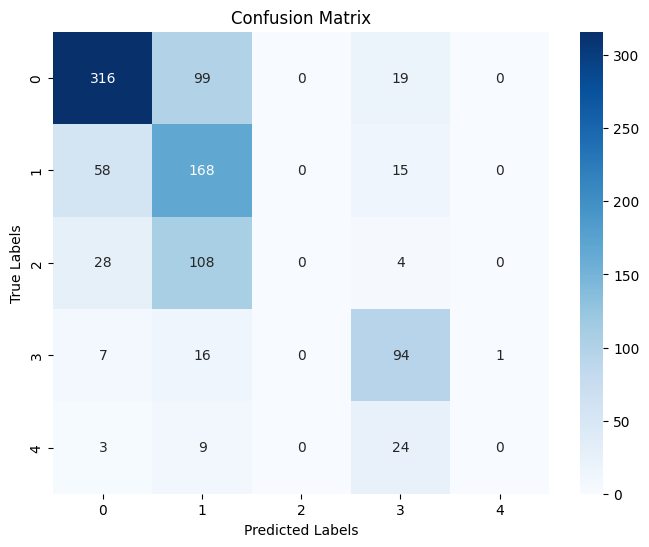

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = cm(y_pred=predicted_labels, y_true=true_labels)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(true_labels), yticklabels=set(true_labels))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


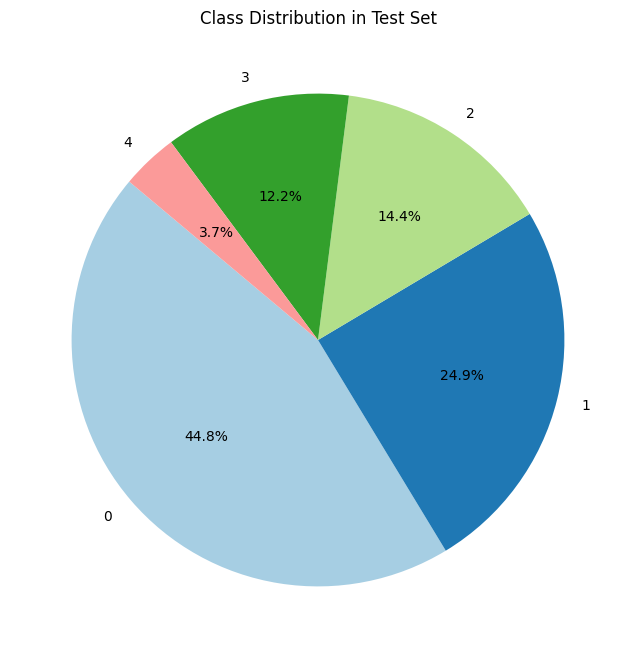

In [32]:
# Compute class distribution
unique_labels, label_counts = np.unique(true_labels, return_counts=True)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Class Distribution in Test Set")
plt.show()


In [19]:

# Save model and tokenizer
trainer.save_model("models/" + model_name_saving)
tokenizer.save_pretrained("models/" + model_name_saving)

('models/bert-base-uncased\\tokenizer_config.json',
 'models/bert-base-uncased\\special_tokens_map.json',
 'models/bert-base-uncased\\vocab.txt',
 'models/bert-base-uncased\\added_tokens.json',
 'models/bert-base-uncased\\tokenizer.json')

In [22]:
logger.info(f"Training metrics ")

for step in enumerate(trainer.state.log_history):
    logger.info(f"{step}")


In [24]:
for step in enumerate(trainer.state.log_history):
    print(f"{step}")

(0, {'loss': 1.3258, 'grad_norm': 9.041976928710938, 'learning_rate': 4.823321554770318e-05, 'epoch': 0.35335689045936397, 'step': 100})
(1, {'loss': 1.1524, 'grad_norm': 9.06457805633545, 'learning_rate': 4.646643109540637e-05, 'epoch': 0.7067137809187279, 'step': 200})
(2, {'eval_loss': 1.0028458833694458, 'eval_accuracy': 0.5923632610939112, 'eval_runtime': 8.1056, 'eval_samples_per_second': 119.547, 'eval_steps_per_second': 7.526, 'epoch': 1.0, 'step': 283})
(3, {'loss': 1.0215, 'grad_norm': 10.007211685180664, 'learning_rate': 4.469964664310954e-05, 'epoch': 1.0600706713780919, 'step': 300})
(4, {'loss': 0.8585, 'grad_norm': 7.505438804626465, 'learning_rate': 4.2932862190812724e-05, 'epoch': 1.4134275618374559, 'step': 400})
(5, {'loss': 0.8609, 'grad_norm': 10.362479209899902, 'learning_rate': 4.11660777385159e-05, 'epoch': 1.76678445229682, 'step': 500})
(6, {'eval_loss': 0.925593912601471, 'eval_accuracy': 0.631578947368421, 'eval_runtime': 6.9776, 'eval_samples_per_second': 1